# Proprocessing of input data for EDGAR v5 N2O Emissions of Africa for 2015 analysis

Data sources:  
- EDGAR v5 data [source](https://edgar.jrc.ec.europa.eu/overview.php?v=50_GHG)  
- Bioclimatic zones [source](https://)
- Livestock numbers [source](https://)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

module_path = Path.cwd().resolve()
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geo import create_area_grid, fix_coords
# import patched path (contains ls())
from utils.misc import Path

In [3]:
data_path = Path('data')

In [4]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            da = da * 3600 * 24 * 365 * 10000
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    # make sure we have clean 2 digit lons
    da = da.assign_coords(lon=da.lon.round(2))
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

## Bioclimatic zones

Load the GeoTiff produced by resampling to 0.1x0.1deg in ArcGIS.

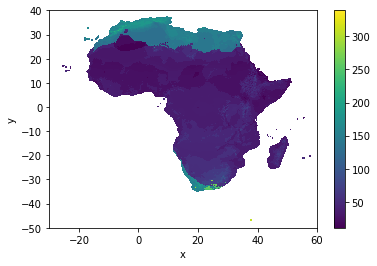

In [5]:
# load bioclimate data (import of resampled geotiff/ source: ArcGIS resampling)
bioclim = xr.open_rasterio(data_path / "africa_bioclimate_01deg.tif").squeeze(drop=True)
bioclim = fix_coords(bioclim, res=0.1)
bioclim = bioclim.where(bioclim != -32768).where(bioclim>0)
bioclim.plot();

In [6]:
# load lookup table
lut = pd.read_csv(data_path / "africa_bioclimate.csv")
display(lut.head())

ombro = lut.groupby(lut.ombro_code).px_value.apply(list)
ombro

,px_value,thermo_code,thermo_type,ombro_code,ombro_type
0,11,1,Lower Infratropical,1,Ultrahyperarid
1,12,1,Lower Infratropical,2,Hyperarid
2,13,1,Lower Infratropical,3,Arid
3,14,1,Lower Infratropical,4,Semi-Arid
4,15,1,Lower Infratropical,5,Dry


ombro_code
1    [11, 21, 31, 41, 51, 61, 71, 131, 141, 151, 16...
2    [12, 22, 32, 42, 52, 62, 72, 82, 132, 142, 152...
3    [13, 23, 33, 43, 53, 63, 73, 83, 93, 133, 143,...
4    [14, 24, 34, 44, 54, 64, 74, 84, 94, 134, 144,...
5    [15, 25, 35, 45, 55, 65, 75, 85, 135, 145, 155...
6    [16, 26, 36, 46, 56, 66, 76, 86, 96, 156, 166,...
7    [17, 27, 37, 47, 57, 67, 77, 87, 97, 107, 157,...
8           [28, 38, 48, 58, 68, 78, 88, 98, 108, 288]
9      [79, 89, 99, 109, 119, 129, 309, 319, 329, 339]
Name: px_value, dtype: object

Load lookup table and create code 2 name mapper

In [7]:
ombro_lu = {k:v for k, v  in zip(lut.ombro_code, lut.ombro_type)}
ombro_lu

{1: 'Ultrahyperarid',
 2: 'Hyperarid',
 3: 'Arid',
 4: 'Semi-Arid',
 5: 'Dry',
 6: 'Subhumid',
 7: 'Humid',
 8: 'Hyperhumid',
 9: 'Ultrahyperhumid'}

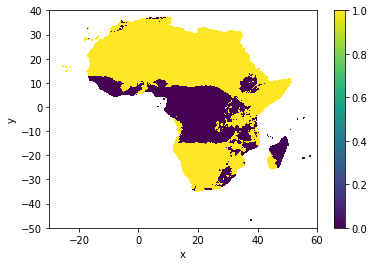

In [8]:
# replace values to ombro types
# bioclim_ombro: all ombro classes (1...9)
# bioclim_dry: only dry ombro classes (1...5)
bioclim_ombro = bioclim.copy(deep=True)
bioclim_dry = bioclim.copy(deep=True)
for i in range(1, 10):
    # all ombro types
    bioclim_ombro = xr.where(bioclim.isin(ombro[i]) == True, i, bioclim_ombro)
bioclim_dry = xr.where(bioclim_ombro.isin([1,2,3,4,5]) == True, 1, 0).where(bioclim_ombro > 0)
bioclim_dry.plot();

In [9]:
bioclim_dry = bioclim_dry.rename({'x': 'lon', 'y': 'lat'})
bioclim_ombro = bioclim_ombro.rename({'x': 'lon', 'y': 'lat'})

dsout = xr.Dataset()
dsout['dry'] = bioclim_dry.astype('float32')
dsout['ombro'] = bioclim_ombro.astype('float32')

# sort latitude to go from net to pos
dsout = dsout.sortby(dsout.lat)

# change type of coords to float32
#dsout = dsout.assign_coords(lon=dsout.lon.astype('float32'))
#dsout = dsout.assign_coords(lat=dsout.lat.astype('float32'))

dsout.to_netcdf('bioclimates.nc')

In [10]:
# load bioclimates again
bioclim_dry = xr.open_dataset("bioclimates.nc")['dry']
bioclim_ombro = xr.open_dataset("bioclimates.nc")['ombro']

# Create mask dataset

In [11]:
# africa/ sub-sahara masks
# codes can be obtained from the lut files in data/tmworld
admin = xr.open_dataset(data_path / 'tmworld' / 'tmworld_01deg.nc').sel(lat=slice(-50,40), lon=slice(-30, 60))

# fix lon to 2 digit precision
admin = fix_coords(admin)

# take africa, substract northern africa, add sudan
africa = admin.REGION.where(admin.REGION == 2).notnull()
africa = africa.where(africa == 1)

subafrica = (admin.SUBREGION.where(admin.REGION == 2)
                            .where(admin.SUBREGION != 15)).notnull()
subafrica = admin.UN.where(admin.UN==736).notnull() + subafrica
subafrica = subafrica.where(subafrica == 1)

mask = xr.Dataset()
mask['africa'] = africa
mask['subsahara'] = subafrica
mask.to_netcdf('mask.nc')

# Create area grid

In [12]:
# create an area grid for calculation of totals (use n2o data grid as ref)
# ref used to create area grid
ref = xr.open_dataset(data_path / 'v50_N2O_2015' / 'v50_N2O_2015.0.1x0.1.nc')['emi_n2o']
ref = fix_coords(ref)
ref = preprocess_edgar_nc(ref)

area = create_area_grid(ref)
area = area.sel(lat=slice(-50,40), lon=slice(-30, 60))
area.to_netcdf('area.nc')

In [13]:
# check area africa ~ 30mio km2
(area*africa).sum().values.round(1)/100

29792319.89

# Checks

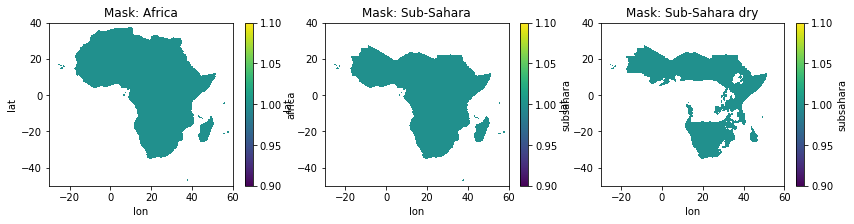

In [14]:
africa = xr.open_dataset('mask.nc')['africa'].where(bioclim_ombro > 0)
subsahara = xr.open_dataset('mask.nc')['subsahara'].where(bioclim_ombro > 0)
subsaharadry = xr.open_dataset('mask.nc')['subsahara'].where(bioclim_dry == 1)

fig, ax = plt.subplots(1, 3 , figsize=(14,3))
africa.plot(ax=ax[0])
subsahara.plot(ax=ax[1])
subsaharadry.plot(ax=ax[2])
ax[0].set_title("Mask: Africa")
ax[1].set_title("Mask: Sub-Sahara")
ax[2].set_title("Mask: Sub-Sahara dry");

# Create livestock grids

We first need to convert the ESRI Binary Grid files from Jaber to GeoTiffs and/ or netcdfs:

```bash
$ gdal_translate -of GTiff af-sh/w001001.adf af-sh.tif 
```

In [41]:
a_ct = xr.open_rasterio(data_path / 'resampled-population' / 'af-ct.tif').squeeze(drop=True)
a_sh = xr.open_rasterio(data_path / 'resampled-population' / 'af-sh.tif').squeeze(drop=True)
a_gt = xr.open_rasterio(data_path / 'resampled-population' / 'af-gt.tif').squeeze(drop=True)

In [42]:
a_ct = a_ct.rename({'x': 'lon', 'y': 'lat'})
a_sh = a_sh.rename({'x': 'lon', 'y': 'lat'})
a_gt = a_gt.rename({'x': 'lon', 'y': 'lat'})

# we also need to correct the numbers since the original values were based on count per 0.083333x0.833333deg grids
# and resampled to 0.1x0.1
conv_factor = 0.1**2 / (0.0833333*0.0833333)

dsout = xr.Dataset()
dsout['cattle'] = a_ct.where(a_ct > -1).astype('float32') * conv_factor
dsout['sheep'] = a_sh.where(a_sh > -1).astype('float32') * conv_factor
dsout['goats'] = a_gt.where(a_gt > -1).astype('float32') * conv_factor

dsout['cattle'].attrs

dsout = dsout.sortby(dsout.lat)
# important so we can do a multiply and not loose cells !!! 
# check that we have 900x900 afterwards (float32/64 mismatch multi will give 180x180!) 
dsout['lat'] = dsout['lat'].astype('float32')
dsout['lon'] = dsout['lon'].astype('float32')

# add units
dsout['cattle'].attrs['units'] = "livestock count gridcell-1"
dsout['sheep'].attrs['units'] = "livestock count gridcell-1"
dsout['goats'].attrs['units'] = "livestock count gridcell-1"

In [43]:
dsout = dsout * africa 

In [45]:
dsout.to_netcdf("livestock.nc")